In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split

C:\Users\JA60301\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
# -------------------------
# 0) 공통 설정
# -------------------------
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

EPOCHS = 20
BATCH_SIZE = 64

In [4]:
# -------------------------
# 1) Data Load & Split (공정비교 핵심)
# -------------------------
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = tf.keras.datasets.cifar10.load_data()

# Baseline용 정규화 (0~1)
x_train_base = x_train_raw.astype("float32") / 255.0
x_test_base  = x_test_raw.astype("float32") / 255.0

# Train / Val split (stratify + seed 고정)
x_tr_base, x_val_base, y_tr, y_val = train_test_split(
    x_train_base, y_train_raw,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train_raw
)

In [5]:
# -------------------------
# 2) Baseline CNN Model
# -------------------------
def build_baseline_model(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [6]:
# -------------------------
# 3) Data Augmentation (ImageDataGenerator)
# -------------------------
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_tr_base)  # 통계 기반 증강(일부 설정에서 필요)

In [7]:
# -------------------------
# 4) (1) Baseline - No Aug
# -------------------------
model_base_noaug = build_baseline_model()
hist_base_noaug = model_base_noaug.fit(
    x_tr_base, y_tr,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_val_base, y_val),
    shuffle=True,
    verbose=1
)
val_base_noaug_20 = hist_base_noaug.history["val_accuracy"]

C:\Users\JA60301\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4471 - loss: 1.5366 - val_accuracy: 0.5602 - val_loss: 1.2553
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5803 - loss: 1.1922 - val_accuracy: 0.6290 - val_loss: 1.0913
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6318 - loss: 1.0578 - val_accuracy: 0.6492 - val_loss: 1.0319
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6606 - loss: 0.9733 - val_accuracy: 0.6564 - val_loss: 1.0100
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6857 - loss: 0.9061 - val_accuracy: 0.6649 - val_loss: 0.9934
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7066 - loss: 0.8514 - val_accuracy: 0.6723 - val_loss: 0.9787
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7225 - loss: 0.8039 - val_accuracy: 0.6803 - val_loss: 0.9702
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7387 - loss: 0.7593 - val_acc

In [8]:
# -------------------------
# 5) (2) Baseline + Aug
# -------------------------
model_base_aug = build_baseline_model()
hist_base_aug = model_base_aug.fit(
    datagen.flow(x_tr_base, y_tr, batch_size=BATCH_SIZE, shuffle=True, seed=SEED),
    epochs=EPOCHS,
    validation_data=(x_val_base, y_val),
    verbose=1
)
val_base_aug_20 = hist_base_aug.history["val_accuracy"]

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.3906 - loss: 1.6771 - val_accuracy: 0.5187 - val_loss: 1.3566
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.4984 - loss: 1.4003 - val_accuracy: 0.5757 - val_loss: 1.2128
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.5441 - loss: 1.2800 - val_accuracy: 0.5891 - val_loss: 1.1495
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.5718 - loss: 1.2102 - val_accuracy: 0.6264 - val_loss: 1.0745
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.5901 - loss: 1.1612 - val_accuracy: 0.6306 - val_loss: 1.0631
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.6006 - loss: 1.1338 - val_accuracy: 0.6536 - val_loss: 1.0024
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.6102 - loss: 1.0970 - val_accuracy: 0.6449 - val_loss: 1.0205
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.6212 - loss: 1.0769 - 

In [9]:
# -------------------------
# 6) Transfer Learning 데이터 준비 (96x96 + preprocess_input)
# -------------------------
def resize_and_preprocess(x):
    # x: (N,32,32,3) float32 0~255 or 0~1 상관 없음
    x = tf.image.resize(x, (96, 96)).numpy()
    x = preprocess_input(x)  # MobileNetV2 전용 (-1~1)
    return x

# TL용은 원본(raw) 기반으로 resize+preprocess
x_tr_raw, x_val_raw, y_tr_tl, y_val_tl = train_test_split(
    x_train_raw, y_train_raw,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train_raw
)

x_tr_tl  = resize_and_preprocess(x_tr_raw.astype("float32"))
x_val_tl = resize_and_preprocess(x_val_raw.astype("float32"))

# TL Aug도 같은 datagen을 쓰되, TL 입력 크기에 맞춰 새로 정의
datagen_tl = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen_tl.fit(x_tr_tl)

In [10]:
# -------------------------
# 7) Transfer Model (MobileNetV2 + Head)
# -------------------------
def build_transfer_model():
    base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(96, 96, 3))
    base.trainable = False

    inputs = Input(shape=(96, 96, 3))
    x = base(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(10, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model, base

def train_transfer_20ep(train_flow, x_val, y_val):
    # 10ep Freeze + 10ep Fine-tune = 20ep
    model, base = build_transfer_model()

    # Step 1: Freeze 10ep
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    h1 = model.fit(train_flow, epochs=10, validation_data=(x_val, y_val), verbose=1)

    # Step 2: Fine-tune 10ep (상위 20 layer만 학습)
    base.trainable = True
    for layer in base.layers[:-20]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    h2 = model.fit(train_flow, epochs=10, validation_data=(x_val, y_val), verbose=1)

    val_acc_20 = h1.history["val_accuracy"] + h2.history["val_accuracy"]
    return model, val_acc_20

In [11]:
# -------------------------
# 8) (3) Transfer - No Aug
# -------------------------
flow_tl_noaug = ImageDataGenerator().flow(
    x_tr_tl, y_tr_tl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)
model_tl_noaug, val_tl_noaug_20 = train_transfer_20ep(flow_tl_noaug, x_val_tl, y_val_tl)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 215ms/step - accuracy: 0.8173 - loss: 0.5395 - val_accuracy: 0.8479 - val_loss: 0.4400
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 200ms/step - accuracy: 0.8703 - loss: 0.3802 - val_accuracy: 0.8534 - val_loss: 0.4260
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 135s 217ms/step - accuracy: 0.8861 - loss: 0.3274 - val_accuracy: 0.8580 - val_loss: 0.4097
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 130s 208ms/step - accuracy: 0.8982 - loss: 0.2908 - val_accuracy: 0.8557 - val_loss: 0.4137
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 204ms/step - accuracy: 0.9086 - loss: 0.2615 - val_accuracy: 0.8527 - val_loss: 0.4463
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 202ms/step - accuracy: 0.9184 - loss: 0.2310 - val_accuracy: 0.8565 - val_loss: 0.4429
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 204ms/step - accuracy: 0.9294 - loss: 0.2040 - val_accuracy: 0.8606 - val_loss: 0.4379
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 199ms/step - accuracy: 0.9376 -

In [12]:
# -------------------------
# 9) (4) Transfer + Aug
# -------------------------
flow_tl_aug = datagen_tl.flow(
    x_tr_tl, y_tr_tl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)
model_tl_aug, val_tl_aug_20 = train_transfer_20ep(flow_tl_aug, x_val_tl, y_val_tl)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 189s 295ms/step - accuracy: 0.7535 - loss: 0.7206 - val_accuracy: 0.8377 - val_loss: 0.4849
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 292ms/step - accuracy: 0.8110 - loss: 0.5537 - val_accuracy: 0.8450 - val_loss: 0.4575
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 293ms/step - accuracy: 0.8190 - loss: 0.5215 - val_accuracy: 0.8490 - val_loss: 0.4432
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 292ms/step - accuracy: 0.8268 - loss: 0.4979 - val_accuracy: 0.8478 - val_loss: 0.4617
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 184s 294ms/step - accuracy: 0.8310 - loss: 0.4827 - val_accuracy: 0.8583 - val_loss: 0.4226
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 294ms/step - accuracy: 0.8355 - loss: 0.4741 - val_accuracy: 0.8541 - val_loss: 0.4314
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 184s 294ms/step - accuracy: 0.8407 - loss: 0.4574 - val_accuracy: 0.8498 - val_loss: 0.4444
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 293ms/step - accuracy: 0.8406 -

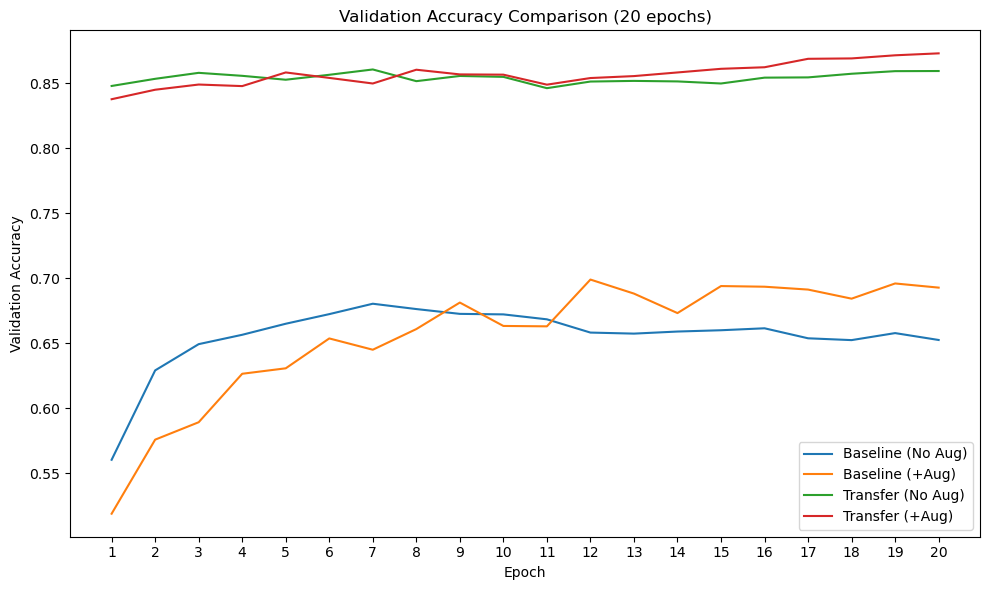

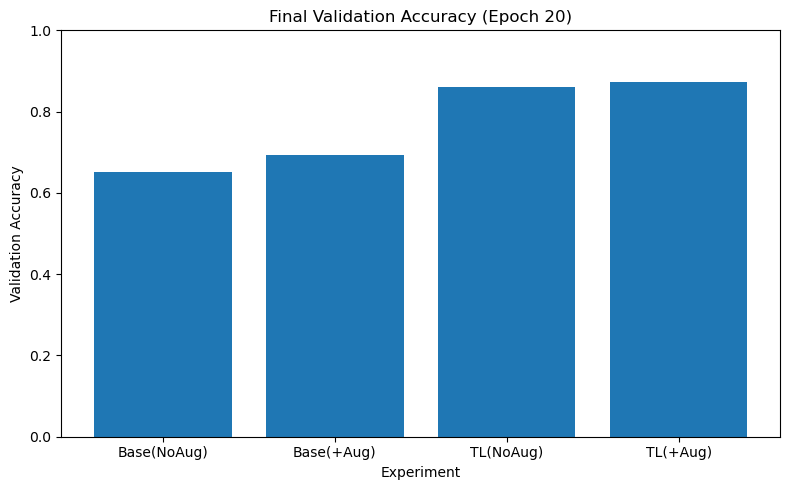

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# 10) Plot - 20epoch val_accuracy curve (4 lines)
# -------------------------
epochs = np.arange(1, 21)

plt.figure(figsize=(10, 6))
plt.plot(epochs, val_base_noaug_20, label="Baseline (No Aug)")
plt.plot(epochs, val_base_aug_20,   label="Baseline (+Aug)")
plt.plot(epochs, val_tl_noaug_20,   label="Transfer (No Aug)")
plt.plot(epochs, val_tl_aug_20,     label="Transfer (+Aug)")

plt.title("Validation Accuracy Comparison (20 epochs)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.xticks(epochs)
plt.legend()
plt.tight_layout()
plt.show()


# -------------------------
# 11) Plot - Final val accuracy bar chart (epoch 20)
# -------------------------
labels = ["Base(NoAug)", "Base(+Aug)", "TL(NoAug)", "TL(+Aug)"]
final_vals = [
    val_base_noaug_20[-1],
    val_base_aug_20[-1],
    val_tl_noaug_20[-1],
    val_tl_aug_20[-1],
]

plt.figure(figsize=(8, 5))
plt.bar(labels, final_vals)
plt.title("Final Validation Accuracy (Epoch 20)")
plt.xlabel("Experiment")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



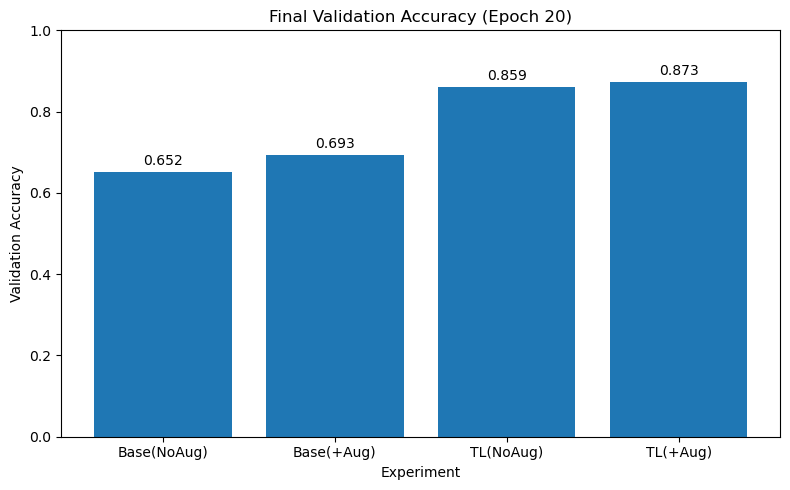

In [18]:
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, final_vals)

plt.title("Final Validation Accuracy (Epoch 20)")
plt.xlabel("Experiment")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)

# 🔹 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,              # 막대 위 약간 띄우기
        f"{height:.3f}",            # 소수 3자리
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()
